In [135]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [136]:
NUM_EXPERIENCES = 10
# DATA_PATH = f"./logs/ST_SplitCIFAR100_{NUM_EXPERIENCES}"
# DATA_PATH = f"./logs/F_SplitCIFAR100_3" # Joint
# DATA_PATH = f"./logs/SplitCIFAR100_Naive"
DATA_PATH = f"./logs/SplitCIFAR100_Replay"
DATASET = "SplitCIFAR100"
MODEL_NAME = "ResNet110"
valid_colors = ['green', 'red', 'cyan', 'magenta', 'black', 'purple', 'orange', 'brown', 'gray', 'olive', 'indigo', 'turquoise']

In [137]:
# all combinations of training
if NUM_EXPERIENCES == 5:
    run2name = {
        "n_nst_npp" : "Naive_NoSelfTraining_NoPostProcessing",
        "n_st_npp_0075" : "Naive_SelfTraining_0.075_NoPostProcessing",
        "n_st_npp_005" : "Naive_SelfTraining_0.05_NoPostProcessing",
        "n_st_npp_00075" : "Naive_SelfTraining_0.0075_NoPostProcessing",
        # "n_nst_pp" : "Naive_NoSelfTraining_PostProcessing",
        # "n_nst_pp_md" : "Naive_NoSelfTraining_PostProcessing_MixedData",

        "r_nst_npp" : "Replay_NoSelfTraining_NoPostProcessing",
        "r_st_npp_0075" : "Replay_SelfTraining_0.075_NoPostProcessing",
        "r_st_npp_005" : "Replay_SelfTraining_0.05_NoPostProcessing",
        "r_st_npp_00075" : "Replay_SelfTraining_0.0075_NoPostProcessing",
        # "r_nst_pp" : "Replay_NoSelfTraining_PostProcessing",
        # "r_nst_pp_md" : "Replay_NoSelfTraining_PostProcessing_MixedData",
        
        "j_nst_npp" : "JointTraining_NoSelfTraining_NoPostProcessing",
        # "j_st_npp_1" : "JointTraining_SelfTraining1.0_NoPostProcessing",
        # "j_st_npp_01" : "JointTraining_SelfTraining0.1_NoPostProcessing",
        "j_st_npp_0075" : "JointTraining_SelfTraining_0.075_NoPostProcessing",
        "j_st_npp_005" : "JointTraining_SelfTraining_0.05_NoPostProcessing",
        # "j_st_npp_0025" : "JointTraining_SelfTraining0.025_NoPostProcessing",
        # "j_st_npp_001" : "JointTraining_SelfTraining0.01_NoPostProcessing",
        "j_st_npp_00075" : "JointTraining_SelfTraining_0.0075_NoPostProcessing",
        # "j_st_npp_0005" : "JointTraining_SelfTraining0.005_NoPostProcessing",
        # "j_st_npp_00025" : "JointTraining_SelfTraining0.0025_NoPostProcessing",
        # "j_st_npp" : "JointTraining_SelfTraining_NoPostProcessing", # 0.001
        # "j_nst_pp" : "JointTraining_NoSelfTraining_PostProcessing"
    }
else:
    run2name = {
        # "n_nst_npp" : "Naive_NoSelfTraining_NoPostProcessing",
        # "n_st_npp_01" : "Naive_SelfTraining_0.1_NoPostProcessing",
        # "n_st_npp_005" : "Naive_SelfTraining_0.05_NoPostProcessing",
        # "n_st_npp_0025" : "Naive_SelfTraining_0.025_NoPostProcessing",
        # # "n_nst_pp" : "Naive_NoSelfTraining_PostProcessing",
        # # "n_nst_pp_md" : "Naive_NoSelfTraining_PostProcessing_MixedData",

        # "r_nst_npp" : "Replay_NoSelfTraining_NoPostProcessing",
        # "r_st_npp_01" : "Replay_SelfTraining_0.1_NoPostProcessing",
        # "r_st_npp_005" : "Replay_SelfTraining_0.05_NoPostProcessing",
        # "r_st_npp_0025" : "Replay_SelfTraining_0.025_NoPostProcessing",
        # # "r_nst_pp" : "Replay_NoSelfTraining_PostProcessing",
        # # "r_nst_pp_md" : "Replay_NoSelfTraining_PostProcessing_MixedData",
        
        # "j_nst_npp" : "JointTraining_NoSelfTraining_NoPostProcessing",
        # # "j_st_npp_1" : "JointTraining_SelfTraining1.0_NoPostProcessing",
        # "j_st_npp_01" : "JointTraining_SelfTraining_0.1_NoPostProcessing", #
        # # "j_st_npp_0075" : "JointTraining_SelfTraining0.075_NoPostProcessing",
        # "j_st_npp_005" : "JointTraining_SelfTraining_0.05_NoPostProcessing", #
        # "j_st_npp_0025" : "JointTraining_SelfTraining_0.025_NoPostProcessing", #
        # # "j_st_npp_001" : "JointTraining_SelfTraining0.01_NoPostProcessing",
        # # "j_st_npp_00075" : "JointTraining_SelfTraining0.0075_NoPostProcessing",
        # # "j_st_npp_0005" : "JointTraining_SelfTraining0.005_NoPostProcessing",
        # # "j_st_npp_00025" : "JointTraining_SelfTraining0.0025_NoPostProcessing",
        # # "j_st_npp" : "JointTraining_SelfTraining_NoPostProcessing", # 0.001
        # # "j_nst_pp" : "JointTraining_NoSelfTraining_PostProcessing"

        # "j_nst_npp_v1" : "JointTraining_NoSelfTraining_NoPostProcessing1",
        # "j_nst_npp_v2" : "JointTraining_NoSelfTraining_NoPostProcessing2",
        # "j_nst_npp_v3" : "JointTraining_NoSelfTraining_NoPostProcessing3",
        # "j_st_npp_0025_v1" : "JointTraining_SelfTraining_0.025_NoPostProcessing1",
        # "j_st_npp_0025_v2" : "JointTraining_SelfTraining_0.025_NoPostProcessing2",
        # "j_st_npp_0025_v3" : "JointTraining_SelfTraining_0.025_NoPostProcessing3",

        # "n_nst_npp_v1" : "Naive_NoSelfTraining_NoPostProcessing1",
        # "n_nst_npp_v2" : "Naive_NoSelfTraining_NoPostProcessing2",
        # "n_nst_npp_v3" : "Naive_NoSelfTraining_NoPostProcessing3",

        # "n_st_npp_01" : "Naive_SelfTraining_0.1_NoPostProcessing1", #
        # # "n_st_npp_01_v2" : "Naive_SelfTraining_0.1_NoPostProcessing2", #
        # "n_st_npp_01_v3" : "Naive_SelfTraining_0.1_NoPostProcessing3", #
        # "n_st_npp_01_v4" : "Naive_SelfTraining_0.1_NoPostProcessing4", #
        # "n_st_npp_0075" : "Naive_SelfTraining_0.075_NoPostProcessing1", #
        # "n_st_npp_0075_v2" : "Naive_SelfTraining_0.075_NoPostProcessing2", #
        # "n_st_npp_0075_v3" : "Naive_SelfTraining_0.075_NoPostProcessing3", #
        # "n_st_npp_0075_v4" : "Naive_SelfTraining_0.075_NoPostProcessing4", #
        # # "n_st_npp_005" : "Naive_SelfTraining_0.05_NoPostProcessing1",
        # # "n_st_npp_0025" : "Naive_SelfTraining_0.025_NoPostProcessing1",
        # # "n_st_npp_001" : "Naive_SelfTraining_0.01_NoPostProcessing1",
        # # "n_st_npp_00075" : "Naive_SelfTraining_0.0075_NoPostProcessing1",
        # # "n_st_npp_0005" : "Naive_SelfTraining_0.005_NoPostProcessing1", #
        # # "n_st_npp_00025" : "Naive_SelfTraining_0.0025_NoPostProcessing1",

        "r_nst_npp_v1" : "Replay_NoSelfTraining_NoPostProcessing1",
        "r_nst_npp_v2" : "Replay_NoSelfTraining_NoPostProcessing2",
        "r_nst_npp_v3" : "Replay_NoSelfTraining_NoPostProcessing3",

        # "r_st_npp_01" : "Replay_SelfTraining_0.1_NoPostProcessing1",
        # "r_st_npp_0075" : "Replay_SelfTraining_0.075_NoPostProcessing1", #
        # "r_st_npp_005" : "Replay_SelfTraining_0.05_NoPostProcessing1",
        "r_st_npp_0025" : "Replay_SelfTraining_0.025_NoPostProcessing1", #
        "r_st_npp_0025_v2" : "Replay_SelfTraining_0.025_NoPostProcessing2", #
        # "r_st_npp_0025_v3" : "Replay_SelfTraining_0.025_NoPostProcessing3", #
        # "r_st_npp_0025_v4" : "Replay_SelfTraining_0.025_NoPostProcessing4", #
        # "r_st_npp_001" : "Replay_SelfTraining_0.01_NoPostProcessing1",
        # "r_st_npp_00075" : "Replay_SelfTraining_0.0075_NoPostProcessing1",
        # "r_st_npp_0005" : "Replay_SelfTraining_0.005_NoPostProcessing1",
        # "r_st_npp_00025" : "Replay_SelfTraining_0.0025_NoPostProcessing1",
    }

In [138]:
run2label = {
    "n_nst_npp" : "Naive",
    "n_st_npp" : "Naive_ST",
    "n_st_npp_01" : "Naive_ST_0.1",
    "n_st_npp_01_v2" : "Naive_ST_0.1",
    "n_st_npp_01_v3" : "Naive_ST_0.1",
    "n_st_npp_01_v4" : "Naive_ST_0.1",
    "n_st_npp_0075" : "Naive_ST_0.075",
    "n_st_npp_0075_v2" : "Naive_ST_0.075",
    "n_st_npp_0075_v3" : "Naive_ST_0.075",
    "n_st_npp_0075_v4" : "Naive_ST_0.075",
    "n_st_npp_005" : "Naive_ST_0.05",
    "n_st_npp_0025" : "Naive_ST_0.025",
    "n_st_npp_001" : "Naive_ST_0.01",
    "n_st_npp_00075" : "Naive_ST_0.0075",
    "n_st_npp_0005" : "Naive_ST_0.005",
    "n_st_npp_00025" : "Naive_ST_0.0025",
    "n_nst_pp" : "Naive_PostProcessing",
    "n_nst_pp_md" : "Naive_PostProcessing_MixedData",

    "r_nst_npp" : "Replay",
    "r_st_npp" : "Replay_ST",
    "r_st_npp_01" : "Replay_ST_0.1",
    "r_st_npp_0075" : "Replay_ST_0.075",
    "r_st_npp_005" : "Replay_ST_0.05",
    "r_st_npp_0025" : "Replay_ST_0.025",
    "r_st_npp_0025_v2" : "Replay_ST_0.025",
    "r_st_npp_0025_v3" : "Replay_ST_0.025",
    "r_st_npp_0025_v4" : "Replay_ST_0.025",
    "r_st_npp_001" : "Replay_ST_0.01",
    "r_st_npp_00075" : "Replay_ST_0.0075",
    "r_st_npp_0005" : "Replay_ST_0.005",
    "r_st_npp_00025" : "Replay_ST_0.0025",
    "r_nst_pp" : "Replay_PostProcessing",
    "r_nst_pp_md" : "Replay_PostProcessing_MixedData",
    
    "j_nst_npp" : "JointTraining",
    "j_st_npp_1" : "JointTraining_ST_1",
    "j_st_npp_01" : "JointTraining_ST_0.1",
    "j_st_npp_001" : "JointTraining_ST_0.01",
    "j_st_npp_005" : "JointTraining_ST_0.05",
    "j_st_npp_0025" : "JointTraining_ST_0.025",
    "j_st_npp_0075" : "JointTraining_ST_0.075",
    "j_st_npp_0005" : "JointTraining_ST_0.005",
    "j_st_npp_00025" : "JointTraining_ST_0.0025",
    "j_st_npp_00075" : "JointTraining_ST_0.0075",
    "j_st_npp" : "JointTraining_ST_0.001",
    "j_nst_pp" : "JointTraining_PostProcessing",

    "j_nst_npp_v1" : "JointTraining",
    "j_nst_npp_v2" : "JointTraining",
    "j_nst_npp_v3" : "JointTraining",
    "j_st_npp_0025_v1" : "JointTraining_ST_0.025",
    "j_st_npp_0025_v2" : "JointTraining_ST_0.025",
    "j_st_npp_0025_v3" : "JointTraining_ST_0.025",

    "n_nst_npp_v1" : "Naive",
    "n_nst_npp_v2" : "Naive",
    "n_nst_npp_v3" : "Naive",

    "r_nst_npp_v1" : "Replay",
    "r_nst_npp_v2" : "Replay",
    "r_nst_npp_v3" : "Replay",
}

In [139]:
running_accuracy = []
running_ece = []
final_accuracy = []
final_ece = []
bins = None
ece_hist_vals = []

for k, name in run2name.items():
    print(f">> {name} <<")
    with open(f"{DATA_PATH}/{DATASET}_{MODEL_NAME}_{name}_dict", "rb") as file:
        data = pickle.load(file)

        # print("\n---- ACCURACY ----")

        metric_str = "Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp"
        m = []
        for i in range(len(data)):
            cur_exp_dict = data[i]
            cur_exp_acc = 0
            # compute the average over the experiences trained so far (i)
            for j in range(i+1):
                # print(i, j, metric_str + f"{j:03d}", cur_exp_dict[metric_str + f"{j:03d}"])
                cur_exp_acc += cur_exp_dict[metric_str + f"{j:03d}"]
            m.append(cur_exp_acc/(i+1))
        
        # duplicate for JointTraining
        if len(m) < NUM_EXPERIENCES:
            m = m*NUM_EXPERIENCES
        running_accuracy.append((k, m))
        final_accuracy.append((k, running_accuracy[-1][-1][-1]))
        # print(k, m, running_accuracy[-1][-1][-1])

        # print("\n---- ECE ----")

        metric_str = "ECE_Exp/eval_phase/test_stream/Task000/Exp"
        m = []
        for i in range(len(data)):
            cur_exp_dict = data[i]
            cur_exp_ece = 0
            # compute the average over the experiences trained so far (i)
            for j in range(i+1):
                # print(i, j, metric_str + f"{j:03d}", cur_exp_dict[metric_str + f"{j:03d}"])
                cur_exp_ece += cur_exp_dict[metric_str + f"{j:03d}"]
            # m.append(cur_exp_ece/(i+1))
            m.append((cur_exp_ece/(i+1))*100)
        
        # duplicate for JointTraining
        if len(m) < NUM_EXPERIENCES:
            m = m*NUM_EXPERIENCES
        running_ece.append((k, m))
        final_ece.append((k, running_ece[-1][-1][-1]))
        # print(k, m, running_ece[-1][-1][-1])

        # print("\n---- ECE HISTOGRAMS ----")

        metric_str = "ExpECEHistogram/eval_phase/test_stream/Exp"
        m = []
        i = -1 # after last experience
        cur_exp_dict = data[i]
        for j in range(NUM_EXPERIENCES):
            # print(i, j, metric_str + f"{j:03d}", cur_exp_dict[metric_str + f"{j:03d}"])
            fig = cur_exp_dict[metric_str + f"{j:03d}"]
            axes_list = fig.get_axes()
            for ax in axes_list:
                for line in ax.get_lines()[-1:]:
                    x_data = line.get_xdata()
                    y_data = line.get_ydata()
                    # print({'x': x_data, 'y': y_data})
                    if bins is None:
                        bins = x_data
                    m.append(y_data)
        # print(bins, m)
        bin_vals = []
        for i in range(len(bins)):
            x = []
            for j in range(len(m)):
                # print(j, i, m[j][i])
                x.append(m[j][i])
            mean = np.mean(x)
            std = np.std(x)
            bin_vals.append((mean, std))
        # print(k, bin_vals)
        ece_hist_vals.append((k, bin_vals))


>> Replay_NoSelfTraining_NoPostProcessing1 <<
>> Replay_NoSelfTraining_NoPostProcessing2 <<
>> Replay_NoSelfTraining_NoPostProcessing3 <<
>> Replay_SelfTraining_0.025_NoPostProcessing1 <<
>> Replay_SelfTraining_0.025_NoPostProcessing2 <<


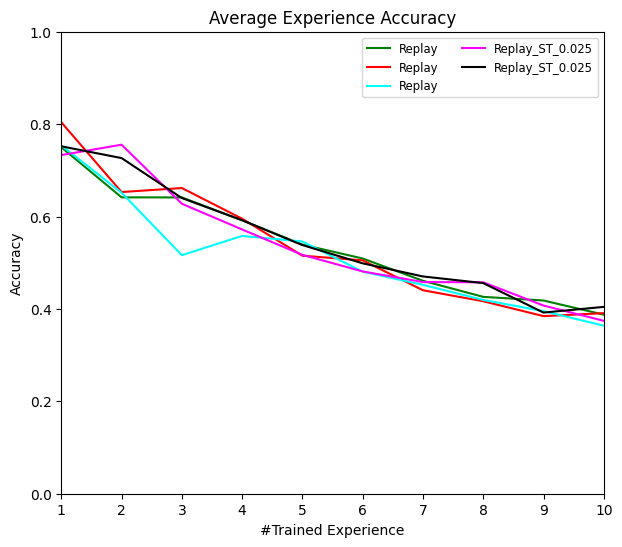

In [140]:
# PLOT 1: Average accuracy on all experiences after training on exp j

plt.figure(figsize=(7, 6))
x_axis = list(range(1, NUM_EXPERIENCES+1))
for i, (name, vals) in enumerate(running_accuracy):
    plt.plot(x_axis, vals, label=run2label[name], color=valid_colors[i])
plt.title('Average Experience Accuracy')
plt.xlabel('#Trained Experience')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xlim(1, NUM_EXPERIENCES)
plt.xticks(x_axis, x_axis)
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.savefig(f'./imgs/{DATASET}_{NUM_EXPERIENCES}_{str.lower("Average_Experience_Accuracy")}.png', dpi=400)
plt.show()

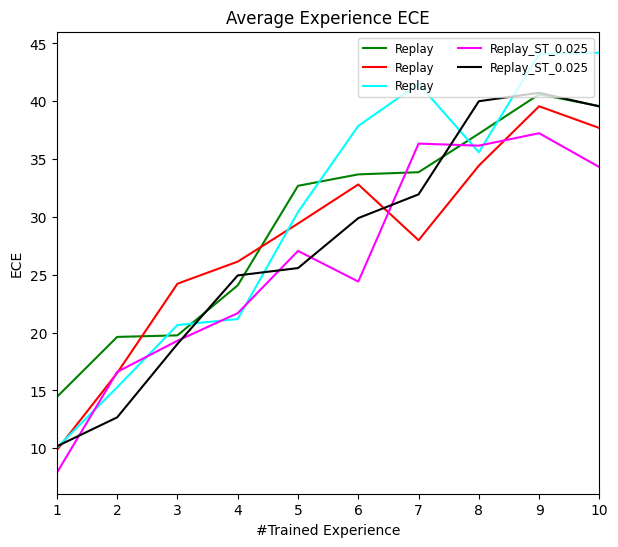

In [141]:
# PLOT 2: Average ece on all experiences after training on exp j

plt.figure(figsize=(7, 6))
x_axis = list(range(1, NUM_EXPERIENCES+1))
for i, (name, vals) in enumerate(running_ece):
    plt.plot(x_axis, vals, label=run2label[name], color=valid_colors[i])
plt.title('Average Experience ECE')
plt.xlabel('#Trained Experience')
plt.ylabel('ECE')
# plt.ylim(0, 1)
plt.xlim(1, NUM_EXPERIENCES)
plt.xticks(x_axis, x_axis)
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.savefig(f'./imgs/{DATASET}_{NUM_EXPERIENCES}_{str.lower("Average_Experience_ECE")}.png', dpi=400)
plt.show()

In [142]:
# TABLE : average accuracy/ece on all experiences at the end of training

table_data = []
for (n, acc), (_, ece) in zip(final_accuracy, final_ece):
    table_data.append((run2label[n], round(acc*100, 2), round(ece, 4)))

dt = pd.DataFrame(table_data, columns=["RunName", "Accuracy", "ECE"])
print(dt)

           RunName  Accuracy      ECE
0           Replay     38.76  39.5783
1           Replay     39.08  37.6858
2           Replay     36.37  44.1951
3  Replay_ST_0.025     37.42  34.3062
4  Replay_ST_0.025     40.44  39.5514


In [143]:
# Calculate mean and standard deviation for each run
mean_accuracy_per_run = dt.groupby('RunName')['Accuracy'].mean()
std_accuracy_per_run = dt.groupby('RunName')['Accuracy'].std()

mean_ece_per_run = dt.groupby('RunName')['ECE'].mean()
std_ece_per_run = dt.groupby('RunName')['ECE'].std()

# Print the results
print("Mean Accuracy per Run:\n", mean_accuracy_per_run)
print("\nStandard Deviation of Accuracy per Run:\n", std_accuracy_per_run)

print("\nMean ECE per Run:\n", mean_ece_per_run)
print("\nStandard Deviation of ECE per Run:\n", std_ece_per_run)

Mean Accuracy per Run:
 RunName
Replay             38.07
Replay_ST_0.025    38.93
Name: Accuracy, dtype: float64

Standard Deviation of Accuracy per Run:
 RunName
Replay             1.480912
Replay_ST_0.025    2.135462
Name: Accuracy, dtype: float64

Mean ECE per Run:
 RunName
Replay             40.4864
Replay_ST_0.025    36.9288
Name: ECE, dtype: float64

Standard Deviation of ECE per Run:
 RunName
Replay             3.348318
Replay_ST_0.025    3.708916
Name: ECE, dtype: float64


In [144]:
print(dt.to_latex(index=False, float_format="{:.2f}".format))

\begin{tabular}{lrr}
\toprule
RunName & Accuracy & ECE \\
\midrule
Replay & 38.76 & 39.58 \\
Replay & 39.08 & 37.69 \\
Replay & 36.37 & 44.20 \\
Replay_ST_0.025 & 37.42 & 34.31 \\
Replay_ST_0.025 & 40.44 & 39.55 \\
\bottomrule
\end{tabular}



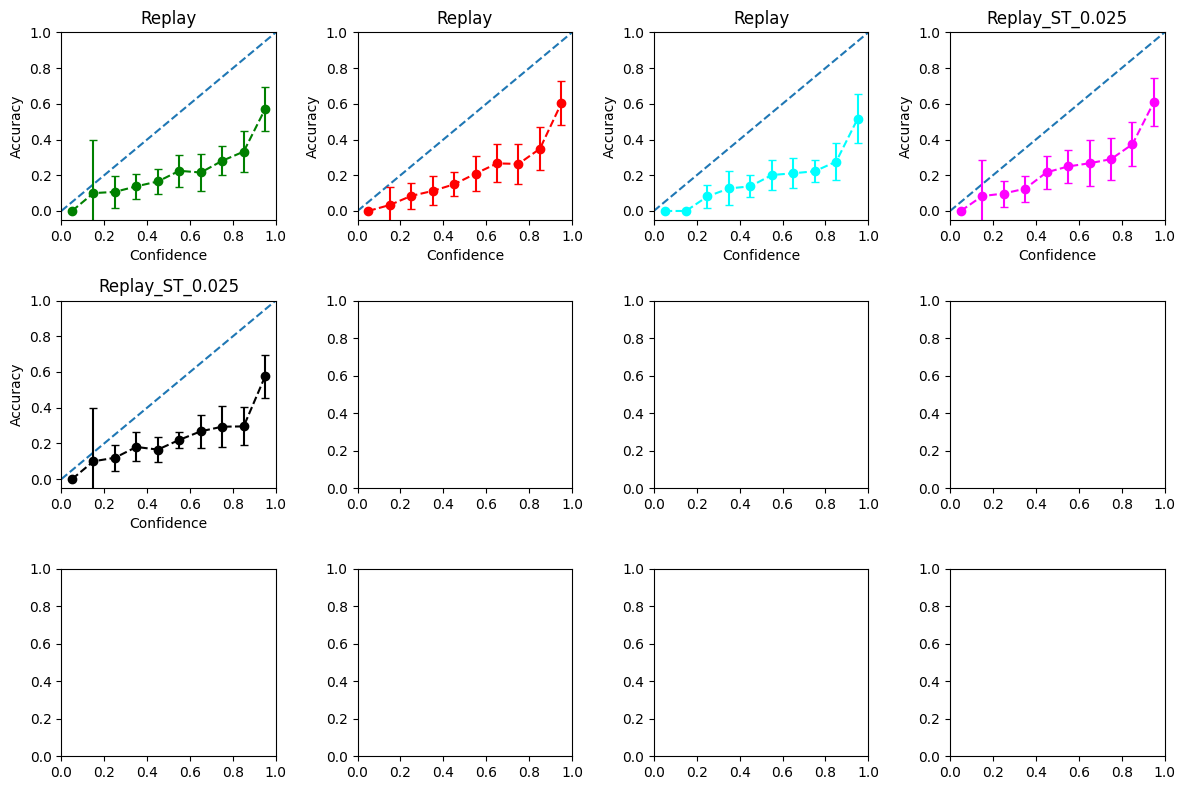

In [145]:
# HISTOGRAM : avg/std across all experiences at the end of training

fig, axs = plt.subplots(3, 4, figsize=(12, 8))
axs = axs.flatten()
for i, (name, vals) in enumerate(ece_hist_vals):
    m = [e[0] for e in vals]
    s = [e[1] for e in vals]
    l = [max(e[0] - e[1], 0) for e in vals] # cap lower-bound at zero
    u = [e[0] + e[1] for e in vals]
    axs[i].plot([0, 1], [0, 1], '--', label='ideal')
    # axs[i].plot(bins, m, color=valid_colors[i])
    # axs[i].fill_between(bins, l, u, alpha=0.3, linestyle='--', color=valid_colors[i])
    axs[i].errorbar(bins, m, yerr=s, marker="o", linestyle="--", capsize=3, capthick=1, color=valid_colors[i])
    axs[i].set_ylim(-0.05, 1)
    axs[i].set_xlim(0, 1)
    axs[i].set_ylabel("Accuracy")
    axs[i].set_xlabel("Confidence")
    # axs[i].legend(loc='upper left', fontsize='small')
    axs[i].set_title(run2label[name])
plt.tight_layout()
plt.savefig(f'./imgs/{DATASET}_{NUM_EXPERIENCES}_avg_std_calibration.png', dpi=400)
plt.show()

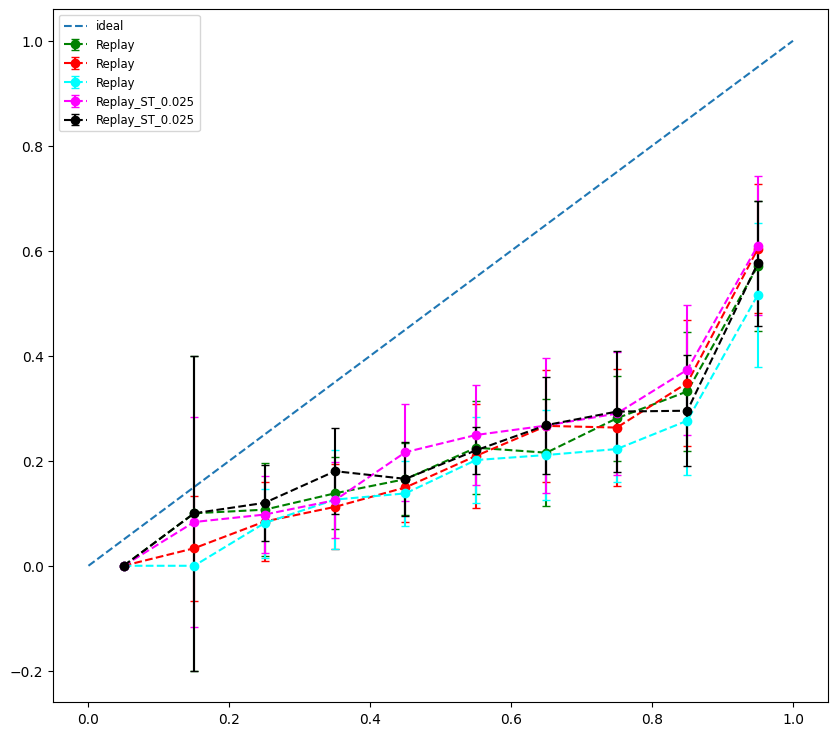

In [146]:
plt.figure(figsize=(10, 9))
plt.plot([0, 1], [0, 1], '--', label='ideal')
for i, (name, vals) in enumerate(ece_hist_vals):
    m = [e[0] for e in vals]
    s = [e[1] for e in vals]
    plt.errorbar(bins, m, yerr=s, marker="o", linestyle="--", capsize=3, capthick=1, color=valid_colors[i], label=run2label[name])
plt.legend(loc='best', fontsize='small')
plt.show()